# Check GPU

In [1]:
#Check for GPU
import tensorflow as tf
# if tf.test.gpu_device_name():
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# else:
#     print('Please install GPU version of TF')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
#check keras and tf versions
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

2.4.3
2.2.0


# Cochleagram Generation

Loads an audio file and generates a cochleagram using the tfcochleagram.py library. 



In [3]:
from __future__ import division
# For displaying audio and images in notebook
#import IPython.display as ipd

from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import time
import os
import sys
from os import listdir
from os.path import isdir, join, dirname, join, realpath
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tfcochleagram
import h5py
import math
# Helper functions for loading audio
from utils import *
import librosa,glob,os

In [4]:
#this is the 4d padding function adapted from Kevin's 2d version
def pad(data_4d, ref_shape, pad_val=-9999):
    '''
    Pads a 4D matrix "data" with the pad_value to make it have shape ref_shape.
    All the padded values occur "off the end" of the data array, so that the
    original array occupies the upper left of the resulting matrix.
    Refer to pad_nans method to pad with nan values
    '''
    padded_data = pad_val*np.ones(ref_shape)
    padded_data[:, :data_4d.shape[1], :data_4d.shape[2], :] = data_4d
    return padded_data

In [5]:
#Here we calculate the longest time and store it into max len
t0 = time.time()
cwd = os.getcwd()
PATH = join(cwd, 'Words')

onlydirs = [f for f in listdir(PATH) if isdir(join(PATH, f))]

total_len = []

for dirs in onlydirs:
    dirname = PATH + "/" + dirs 
    rfnArraymax = [os.path.join(dirname, f)for f in os.listdir(dirname) if f.endswith('.wav')]
    
    for f in rfnArraymax:
        test_audio, SR = load_audio_wav_resample(f, DUR_SECS='full', resample_SR=16000)
        total_len.append(math.ceil(len(test_audio)/80))
        #print(math.ceil(len(test_audio)/80))
max_len = np.max(total_len)
print(max_len)

226


In [6]:
# #Write cochs to individual np arrays
# j = 0
# for dirs in onlydirs:
#     dirname = PATH + "/" + dirs 
#     rfnArray = [os.path.join(dirname, f)for f in os.listdir(dirname) if f.endswith('.wav')]
#     i = 0
    
#     for f in rfnArray:
#         j = j + 1
#         print(j, end='\r')
#         #print('Running demo with sound file: %s ' % f)
#         test_audio, SR = load_audio_wav_resample(f, DUR_SECS='full', resample_SR=20000)
#         # Generally a good idea to rms normalize the audio
#         test_audio = rms_normalize_audio(test_audio, rms_value=0.01)
#         # Using rFFT below, and it is currently implemented only for even # signals. 
#         if len(test_audio.ravel())%2:
#             test_audio = test_audio[:-1]
#             #print(test_audio)
#         if len(test_audio.shape) == 1: # we need to make sure the input node has a first dimension that corresponds to the batch size
#             test_audio = np.expand_dims(test_audio,0) 
#         nets = {}
#         # tfcochleagram expects a dictionary with 'input_signal' defined for the input audio
#         nets['input_signal'] = tf.Variable(test_audio, dtype=tf.float32)
#         nets = tfcochleagram.cochleagram_graph(nets, SR, rFFT=True)
#         #with tf.Session() as sess:
#         #with tf.compat.v1.Session() as sess:
#         nets['input_signal'] = test_audio
#         cochleagram = nets['cochleagram']
#         filters_out = nets['filts_tensor']
        
#         #this is where padding happening
#         cochleagram = pad(cochleagram, (1,211,max_len,1), -9999) #211 is the channels in the coch.
#         cochleagram = cochleagram[:,:,:,0] #here we get rid of the last axis because we do not need depth
#         cochleagram = np.rollaxis(cochleagram,1,3) # here we move the second axis (1) 3 times to make it totalXtimeXchannels
#         #print(cochleagram.shape)
        
#         #save the cochs into pickles
#         MAIN_PATH = join(cwd, 'data')
#         #if isdir(MAIN_PATH + '/%s' %dirs) == False:  #for now we do not want to create subfolders    
#         # os.mkdir(MAIN_PATH + '/%s' %dirs)
        
#         filenames_with_extension = os.listdir(dirname)
        
#         filenames=[x.split('.')[0] for x in filenames_with_extension]
#         filename=filenames[i]
#         i += 1
#         #filex=os.path.basename(filename)       

#         #write to numpy array
#         #f = MAIN_PATH + '/%s' %dirs + '/' + filename #no subfolers under data folder
#         f = MAIN_PATH + '/' + filename
#         np.save(f,cochleagram[0,:,:])
#         #write to pickle
#         #import pickle
#         #with open(MAIN_PATH + '/%s' %dirs + '/' + filename +'.PICKLE', 'wb') as f:
#         #    pickle.dump(cochleagram[:,:,:], f, protocol= 4)
        
# t1 = time.time()
# timer = t1-t0
# print(timer)

# Preprocessing

In [7]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('/autofs/space/euler_001/users/lstm/dicts/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('/autofs/space/euler_001/users/lstm/dicts/labels_ventral.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [8]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=100, dim=(max_len,211), #n_channels=1,
                 n_classes=1007, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*800:(index+1)*800]
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, max_len, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]

        return X, y

# Build and Train LSTM

In [9]:
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Masking, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import json
import pandas as pd
from keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [10]:
# Parameters
params = {'dim': (max_len,211),
          'batch_size': 100,
          'n_classes': 1007,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [11]:
data_dim = 211

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Masking(mask_value=-9999, input_shape=(max_len, data_dim))) #The mask value has to equal whatever the junk value was that you used to pad the inputs. 0. is a bad idea because it might actually occur in the cgram. In EARSHOT we use -9999.
model.add(LSTM(512, return_sequences=True))
model.add(Dense(1007, activation='sigmoid')) 
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = keras.optimizers.Adam(learning_rate=0.0001)#, clipnorm=0.01)
#sgd=SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='mse',
              optimizer=opt)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
_________________________________________________________________
dense (Dense)                (None, 226, 1007)         516591    
Total params: 1,999,343
Trainable params: 1,999,343
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# #load the model from checkpoint
# model = tf.keras.models.load_model('/autofs/space/euler_001/users/lstm/checkpoints/_2000.hd5f')
# print(model.summary())

In [13]:
# Early Stopping and checkpoint
# Set callback functions to early stop training and save the best model so far
# earlystop = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
#              ModelCheckpoint(filepath='VentralModel_EarlyStop.h5', monitor='val_loss', save_best_only=True)]

# checkpoint
checkpoints = ModelCheckpoint('checkpoints/' + '_{epoch:02d}' + '.hd5f',
                              monitor="loss",
                              verbose=0,
                              #save_best_only=True,
                              save_weights_only=False,
                              mode="min",
                              save_freq=7900)

from keras.callbacks import TerminateOnNaN
terminate = TerminateOnNaN()

In [14]:
#Here we train the Network.
#history = model.fit(X_train, Y_train, batch_size=100, epochs=1000, validation_data=(X_valid, Y_valid))
history = model.fit_generator(generator=training_generator,
                              epochs=10000,
                              validation_data=validation_generator,
                              callbacks=[checkpoints], #earlystop,
                              #use_multiprocessing=True,
                              workers=6)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10000
79/79 [==============================] - 31s 393ms/step - loss: 0.1180 - val_loss: 0.1022
Epoch 2/10000
79/79 [==============================] - 26s 326ms/step - loss: 0.1025 - val_loss: 0.1017
Epoch 3/10000
79/79 [==============================] - 24s 306ms/step - loss: 0.1022 - val_loss: 0.1018
Epoch 4/10000
79/79 [==============================] - 30s 375ms/step - loss: 0.1020 - val_loss: 0.1014
Epoch 5/10000
79/79 [==============================] - 24s 300ms/step - loss: 0.1019 - val_loss: 0.1015
Epoch 6/10000
79/79 [==============================] - 27s 337ms/step - loss: 0.1018 - val_loss: 0.1015
Epoch 7/10000
79/79 [==============================] - 29s 370ms/step - loss: 0.1018 - val_loss: 0.1012
Epoch 8/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.1016 - val_loss: 0.1015
Epoch 9/10000
79/79 [==============================] - 29s 364ms/step - loss: 0.1016 - val_l

79/79 [==============================] - 22s 284ms/step - loss: 0.0994 - val_loss: 0.0994
Epoch 77/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0995 - val_loss: 0.0984
Epoch 78/10000
79/79 [==============================] - 27s 346ms/step - loss: 0.0994 - val_loss: 0.0992
Epoch 79/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0993 - val_loss: 0.0996
Epoch 80/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0994 - val_loss: 0.0992
Epoch 81/10000
79/79 [==============================] - 25s 319ms/step - loss: 0.0992 - val_loss: 0.0990
Epoch 82/10000
79/79 [==============================] - 25s 317ms/step - loss: 0.0992 - val_loss: 0.0987
Epoch 83/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0992 - val_loss: 0.0987
Epoch 84/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0993 - val_loss: 0.0991
Epoch 85/10000
79/79 [==============================] - 28s 353ms/step

79/79 [==============================] - 30s 375ms/step - loss: 0.0973 - val_loss: 0.0976
Epoch 149/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0972 - val_loss: 0.0977
Epoch 150/10000
79/79 [==============================] - 29s 361ms/step - loss: 0.0972 - val_loss: 0.0969
Epoch 151/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0971 - val_loss: 0.0969
Epoch 152/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0969 - val_loss: 0.0969
Epoch 153/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0969 - val_loss: 0.0971
Epoch 154/10000
79/79 [==============================] - 25s 320ms/step - loss: 0.0970 - val_loss: 0.0975
Epoch 155/10000
79/79 [==============================] - 25s 319ms/step - loss: 0.0970 - val_loss: 0.0973
Epoch 156/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0968 - val_loss: 0.0973
Epoch 157/10000
79/79 [==============================] - 23s 2

79/79 [==============================] - 29s 365ms/step - loss: 0.0921 - val_loss: 0.0937
Epoch 225/10000
79/79 [==============================] - 35s 448ms/step - loss: 0.0921 - val_loss: 0.0947
Epoch 226/10000
79/79 [==============================] - 26s 335ms/step - loss: 0.0920 - val_loss: 0.0936
Epoch 227/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0916 - val_loss: 0.0941
Epoch 228/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0919 - val_loss: 0.0940
Epoch 229/10000
79/79 [==============================] - 29s 362ms/step - loss: 0.0915 - val_loss: 0.0946
Epoch 230/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0917 - val_loss: 0.0950
Epoch 231/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0916 - val_loss: 0.0937
Epoch 232/10000
79/79 [==============================] - 30s 376ms/step - loss: 0.0915 - val_loss: 0.0929
Epoch 233/10000
79/79 [==============================] - 26s 3

79/79 [==============================] - 26s 333ms/step - loss: 0.0854 - val_loss: 0.0913
Epoch 301/10000
79/79 [==============================] - 21s 265ms/step - loss: 0.0859 - val_loss: 0.0918
Epoch 302/10000
79/79 [==============================] - 21s 267ms/step - loss: 0.0851 - val_loss: 0.0912
Epoch 303/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0855 - val_loss: 0.0905
Epoch 304/10000
79/79 [==============================] - 21s 266ms/step - loss: 0.0856 - val_loss: 0.0912
Epoch 305/10000
79/79 [==============================] - 21s 270ms/step - loss: 0.0855 - val_loss: 0.0919
Epoch 306/10000
79/79 [==============================] - 21s 265ms/step - loss: 0.0848 - val_loss: 0.0914
Epoch 307/10000
79/79 [==============================] - 21s 262ms/step - loss: 0.0845 - val_loss: 0.0910
Epoch 308/10000
79/79 [==============================] - 21s 264ms/step - loss: 0.0846 - val_loss: 0.0916
Epoch 309/10000
79/79 [==============================] - 21s 2

79/79 [==============================] - 21s 267ms/step - loss: 0.0804 - val_loss: 0.0891
Epoch 378/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0804 - val_loss: 0.0889
Epoch 379/10000
79/79 [==============================] - 21s 267ms/step - loss: 0.0807 - val_loss: 0.0893
Epoch 380/10000
79/79 [==============================] - 21s 269ms/step - loss: 0.0802 - val_loss: 0.0892
Epoch 381/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0799 - val_loss: 0.0908
Epoch 382/10000
79/79 [==============================] - 21s 271ms/step - loss: 0.0817 - val_loss: 0.0892
Epoch 383/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0802 - val_loss: 0.0896
Epoch 384/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0799 - val_loss: 0.0895
Epoch 385/10000
79/79 [==============================] - 21s 269ms/step - loss: 0.0798 - val_loss: 0.0895
Epoch 386/10000
79/79 [==============================] - 21s 2

79/79 [==============================] - 21s 269ms/step - loss: 0.0758 - val_loss: 0.0874
Epoch 454/10000
79/79 [==============================] - 21s 269ms/step - loss: 0.0750 - val_loss: 0.0890
Epoch 455/10000
79/79 [==============================] - 21s 271ms/step - loss: 0.0749 - val_loss: 0.0895
Epoch 456/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0751 - val_loss: 0.0890
Epoch 457/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0751 - val_loss: 0.0888
Epoch 458/10000
79/79 [==============================] - 21s 267ms/step - loss: 0.0748 - val_loss: 0.0890
Epoch 459/10000
79/79 [==============================] - 21s 268ms/step - loss: 0.0752 - val_loss: 0.0894
Epoch 460/10000
79/79 [==============================] - 21s 267ms/step - loss: 0.0749 - val_loss: 0.0887
Epoch 461/10000
79/79 [==============================] - 21s 267ms/step - loss: 0.0746 - val_loss: 0.0884
Epoch 462/10000
79/79 [==============================] - 21s 2

79/79 [==============================] - 21s 269ms/step - loss: 0.0706 - val_loss: 0.0889
Epoch 530/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0709 - val_loss: 0.0881
Epoch 531/10000
79/79 [==============================] - 21s 269ms/step - loss: 0.0705 - val_loss: 0.0886
Epoch 532/10000
79/79 [==============================] - 21s 269ms/step - loss: 0.0708 - val_loss: 0.0880
Epoch 533/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0701 - val_loss: 0.0888
Epoch 534/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0702 - val_loss: 0.0891
Epoch 535/10000
79/79 [==============================] - 21s 271ms/step - loss: 0.0702 - val_loss: 0.0890
Epoch 536/10000
79/79 [==============================] - 22s 273ms/step - loss: 0.0746 - val_loss: 0.0919
Epoch 537/10000
79/79 [==============================] - 22s 272ms/step - loss: 0.0792 - val_loss: 0.0890
Epoch 538/10000
79/79 [==============================] - 21s 2

79/79 [==============================] - 22s 275ms/step - loss: 0.0665 - val_loss: 0.0869
Epoch 606/10000
79/79 [==============================] - 22s 275ms/step - loss: 0.0665 - val_loss: 0.0869
Epoch 607/10000
79/79 [==============================] - 22s 274ms/step - loss: 0.0684 - val_loss: 0.0887
Epoch 608/10000
79/79 [==============================] - 22s 277ms/step - loss: 0.0705 - val_loss: 0.0935
Epoch 609/10000
79/79 [==============================] - 22s 274ms/step - loss: 0.0734 - val_loss: 0.0876
Epoch 610/10000
79/79 [==============================] - 21s 271ms/step - loss: 0.0686 - val_loss: 0.0872
Epoch 611/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0672 - val_loss: 0.0875
Epoch 612/10000
79/79 [==============================] - 21s 272ms/step - loss: 0.0671 - val_loss: 0.0872
Epoch 613/10000
79/79 [==============================] - 22s 275ms/step - loss: 0.0673 - val_loss: 0.0876
Epoch 614/10000
79/79 [==============================] - 21s 2

79/79 [==============================] - 22s 277ms/step - loss: 0.0634 - val_loss: 0.0876
Epoch 683/10000
79/79 [==============================] - 22s 276ms/step - loss: 0.0657 - val_loss: 0.0908
Epoch 684/10000
79/79 [==============================] - 22s 275ms/step - loss: 0.0662 - val_loss: 0.0872
Epoch 685/10000
79/79 [==============================] - 22s 274ms/step - loss: 0.0633 - val_loss: 0.0869
Epoch 686/10000
79/79 [==============================] - 22s 276ms/step - loss: 0.0646 - val_loss: 0.0869
Epoch 687/10000
79/79 [==============================] - 22s 275ms/step - loss: 0.0639 - val_loss: 0.0880
Epoch 688/10000
79/79 [==============================] - 22s 274ms/step - loss: 0.0628 - val_loss: 0.0871
Epoch 689/10000
79/79 [==============================] - 22s 276ms/step - loss: 0.0629 - val_loss: 0.0868
Epoch 690/10000
79/79 [==============================] - 22s 274ms/step - loss: 0.0633 - val_loss: 0.0877
Epoch 691/10000
79/79 [==============================] - 22s 2

79/79 [==============================] - 22s 278ms/step - loss: 0.0613 - val_loss: 0.0869
Epoch 759/10000
79/79 [==============================] - 22s 281ms/step - loss: 0.0613 - val_loss: 0.0868
Epoch 760/10000
79/79 [==============================] - 22s 279ms/step - loss: 0.0603 - val_loss: 0.0867
Epoch 761/10000
79/79 [==============================] - 22s 278ms/step - loss: 0.0598 - val_loss: 0.0878
Epoch 762/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0597 - val_loss: 0.0870
Epoch 763/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0601 - val_loss: 0.0871
Epoch 764/10000
79/79 [==============================] - 22s 278ms/step - loss: 0.0711 - val_loss: 0.0877
Epoch 765/10000
79/79 [==============================] - 22s 280ms/step - loss: 0.0635 - val_loss: 0.0872
Epoch 766/10000
79/79 [==============================] - 22s 280ms/step - loss: 0.0609 - val_loss: 0.0874
Epoch 767/10000
79/79 [==============================] - 22s 2

79/79 [==============================] - 22s 284ms/step - loss: 0.0618 - val_loss: 0.0862
Epoch 835/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0632 - val_loss: 0.0940
Epoch 836/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0635 - val_loss: 0.0859
Epoch 837/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0593 - val_loss: 0.0859
Epoch 838/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0585 - val_loss: 0.0865
Epoch 839/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0583 - val_loss: 0.0867
Epoch 840/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0576 - val_loss: 0.0874
Epoch 841/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0582 - val_loss: 0.0862
Epoch 842/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0577 - val_loss: 0.0866
Epoch 843/10000
79/79 [==============================] - 22s 2

79/79 [==============================] - 23s 289ms/step - loss: 0.0555 - val_loss: 0.0863
Epoch 911/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0550 - val_loss: 0.0868
Epoch 912/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0551 - val_loss: 0.0867
Epoch 913/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0592 - val_loss: 0.0849
Epoch 914/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0591 - val_loss: 0.0857
Epoch 915/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0584 - val_loss: 0.0861
Epoch 916/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0579 - val_loss: 0.0858
Epoch 917/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0577 - val_loss: 0.0856
Epoch 918/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0558 - val_loss: 0.0873
Epoch 919/10000
79/79 [==============================] - 23s 2

79/79 [==============================] - 23s 289ms/step - loss: 0.0549 - val_loss: 0.0851
Epoch 988/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0538 - val_loss: 0.0868
Epoch 989/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0535 - val_loss: 0.0864
Epoch 990/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0532 - val_loss: 0.0859
Epoch 991/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0532 - val_loss: 0.0855
Epoch 992/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0533 - val_loss: 0.0863
Epoch 993/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0534 - val_loss: 0.0871
Epoch 994/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0543 - val_loss: 0.0870
Epoch 995/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0541 - val_loss: 0.0864
Epoch 996/10000
79/79 [==============================] - 23s 2

79/79 [==============================] - 23s 291ms/step - loss: 0.0509 - val_loss: 0.0863
Epoch 1063/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0508 - val_loss: 0.0863
Epoch 1064/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0506 - val_loss: 0.0873
Epoch 1065/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0505 - val_loss: 0.0871
Epoch 1066/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0509 - val_loss: 0.0875
Epoch 1067/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0510 - val_loss: 0.0891
Epoch 1068/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0568 - val_loss: 0.0854
Epoch 1069/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0576 - val_loss: 0.0862
Epoch 1070/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0592 - val_loss: 0.0876
Epoch 1071/10000
79/79 [==============================

79/79 [==============================] - 23s 293ms/step - loss: 0.0505 - val_loss: 0.0872
Epoch 1138/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0503 - val_loss: 0.0857
Epoch 1139/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0500 - val_loss: 0.0856
Epoch 1140/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0498 - val_loss: 0.0857
Epoch 1141/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0519 - val_loss: 0.0883
Epoch 1142/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0523 - val_loss: 0.0879
Epoch 1143/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0529 - val_loss: 0.0860
Epoch 1144/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0529 - val_loss: 0.0854
Epoch 1145/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0511 - val_loss: 0.0856
Epoch 1146/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0557 - val_loss: 0.0859
Epoch 1213/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0513 - val_loss: 0.0865
Epoch 1214/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0527 - val_loss: 0.0858
Epoch 1215/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0509 - val_loss: 0.0853
Epoch 1216/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0502 - val_loss: 0.0843
Epoch 1217/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0504 - val_loss: 0.0896
Epoch 1218/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0674 - val_loss: 0.0879
Epoch 1219/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0594 - val_loss: 0.0991
Epoch 1220/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0735 - val_loss: 0.0883
Epoch 1221/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0473 - val_loss: 0.0854
Epoch 1289/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0480 - val_loss: 0.0875
Epoch 1290/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0485 - val_loss: 0.0874
Epoch 1291/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0481 - val_loss: 0.0871
Epoch 1292/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0493 - val_loss: 0.0867
Epoch 1293/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0481 - val_loss: 0.0865
Epoch 1294/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0500 - val_loss: 0.0886
Epoch 1295/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0689 - val_loss: 0.0861
Epoch 1296/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0594 - val_loss: 0.0862
Epoch 1297/10000
79/79 [==============================

79/79 [==============================] - 23s 294ms/step - loss: 0.0655 - val_loss: 0.0852
Epoch 1364/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0516 - val_loss: 0.0853
Epoch 1365/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0490 - val_loss: 0.0847
Epoch 1366/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0484 - val_loss: 0.0858
Epoch 1367/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0472 - val_loss: 0.0852
Epoch 1368/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0465 - val_loss: 0.0868
Epoch 1369/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0461 - val_loss: 0.0866
Epoch 1370/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0460 - val_loss: 0.0862
Epoch 1371/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0458 - val_loss: 0.0858
Epoch 1372/10000
79/79 [==============================

79/79 [==============================] - 23s 296ms/step - loss: 0.0507 - val_loss: 0.0884
Epoch 1439/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0578 - val_loss: 0.0958
Epoch 1440/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0647 - val_loss: 0.0860
Epoch 1441/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0514 - val_loss: 0.0854
Epoch 1442/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0493 - val_loss: 0.0911
Epoch 1443/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0522 - val_loss: 0.0844
Epoch 1444/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0471 - val_loss: 0.0843
Epoch 1445/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0463 - val_loss: 0.0831
Epoch 1446/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0456 - val_loss: 0.0880
Epoch 1447/10000
79/79 [==============================

79/79 [==============================] - 23s 293ms/step - loss: 0.0500 - val_loss: 0.0865
Epoch 1514/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0485 - val_loss: 0.0859
Epoch 1515/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0474 - val_loss: 0.0855
Epoch 1516/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0455 - val_loss: 0.0852
Epoch 1517/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0448 - val_loss: 0.0866
Epoch 1518/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0443 - val_loss: 0.0872
Epoch 1519/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0440 - val_loss: 0.0866
Epoch 1520/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0438 - val_loss: 0.0868
Epoch 1521/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0439 - val_loss: 0.0859
Epoch 1522/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0485 - val_loss: 0.0880
Epoch 1590/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0502 - val_loss: 0.0862
Epoch 1591/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0467 - val_loss: 0.0854
Epoch 1592/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0447 - val_loss: 0.0852
Epoch 1593/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0436 - val_loss: 0.0864
Epoch 1594/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0461 - val_loss: 0.0874
Epoch 1595/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0499 - val_loss: 0.0882
Epoch 1596/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0505 - val_loss: 0.0862
Epoch 1597/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0464 - val_loss: 0.0863
Epoch 1598/10000
79/79 [==============================

79/79 [==============================] - 23s 293ms/step - loss: 0.0419 - val_loss: 0.0866
Epoch 1665/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0493 - val_loss: 0.0906
Epoch 1666/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0570 - val_loss: 0.0915
Epoch 1667/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0697 - val_loss: 0.0858
Epoch 1668/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0531 - val_loss: 0.0859
Epoch 1669/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0490 - val_loss: 0.0850
Epoch 1670/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0458 - val_loss: 0.0839
Epoch 1671/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0441 - val_loss: 0.0869
Epoch 1672/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0437 - val_loss: 0.0857
Epoch 1673/10000
79/79 [==============================

79/79 [==============================] - 23s 293ms/step - loss: 0.0603 - val_loss: 0.0868
Epoch 1740/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0539 - val_loss: 0.0903
Epoch 1741/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0561 - val_loss: 0.0847
Epoch 1742/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0484 - val_loss: 0.0877
Epoch 1743/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0465 - val_loss: 0.0855
Epoch 1744/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0448 - val_loss: 0.0870
Epoch 1745/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0443 - val_loss: 0.0847
Epoch 1746/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0431 - val_loss: 0.0866
Epoch 1747/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0503 - val_loss: 0.0867
Epoch 1748/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0431 - val_loss: 0.0897
Epoch 1815/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0438 - val_loss: 0.0862
Epoch 1816/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0420 - val_loss: 0.0893
Epoch 1817/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0623 - val_loss: 0.0933
Epoch 1818/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0548 - val_loss: 0.0849
Epoch 1819/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0461 - val_loss: 0.0861
Epoch 1820/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0500 - val_loss: 0.0851
Epoch 1821/10000
79/79 [==============================] - 24s 304ms/step - loss: 0.0473 - val_loss: 0.0888
Epoch 1822/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0482 - val_loss: 0.0858
Epoch 1823/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0415 - val_loss: 0.0851
Epoch 1891/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0415 - val_loss: 0.0854
Epoch 1892/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0403 - val_loss: 0.0884
Epoch 1893/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0699 - val_loss: 0.0877
Epoch 1894/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0521 - val_loss: 0.0868
Epoch 1895/10000
79/79 [==============================] - 23s 297ms/step - loss: 0.0501 - val_loss: 0.0854
Epoch 1896/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0448 - val_loss: 0.0843
Epoch 1897/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0430 - val_loss: 0.0872
Epoch 1898/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0416 - val_loss: 0.0864
Epoch 1899/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0389 - val_loss: 0.0876
Epoch 1966/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0389 - val_loss: 0.0867
Epoch 1967/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0392 - val_loss: 0.0856
Epoch 1968/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0389 - val_loss: 0.0878
Epoch 1969/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0386 - val_loss: 0.0881
Epoch 1970/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0385 - val_loss: 0.0879
Epoch 1971/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0389 - val_loss: 0.0883
Epoch 1972/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0390 - val_loss: 0.0874
Epoch 1973/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0415 - val_loss: 0.0870
Epoch 1974/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0385 - val_loss: 0.0892
Epoch 2041/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0383 - val_loss: 0.0887
Epoch 2042/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0381 - val_loss: 0.0883
Epoch 2043/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0382 - val_loss: 0.0877
Epoch 2044/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0383 - val_loss: 0.0893
Epoch 2045/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0388 - val_loss: 0.0904
Epoch 2046/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0429 - val_loss: 0.0891
Epoch 2047/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0470 - val_loss: 0.0873
Epoch 2048/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0631 - val_loss: 0.0944
Epoch 2049/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0417 - val_loss: 0.0870
Epoch 2116/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0404 - val_loss: 0.0872
Epoch 2117/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0401 - val_loss: 0.0876
Epoch 2118/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0406 - val_loss: 0.0871
Epoch 2119/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0403 - val_loss: 0.0851
Epoch 2120/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0396 - val_loss: 0.0870
Epoch 2121/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0391 - val_loss: 0.0868
Epoch 2122/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0389 - val_loss: 0.0874
Epoch 2123/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0388 - val_loss: 0.0886
Epoch 2124/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0404 - val_loss: 0.0864
Epoch 2192/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0400 - val_loss: 0.0858
Epoch 2193/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0393 - val_loss: 0.0859
Epoch 2194/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0389 - val_loss: 0.0870
Epoch 2195/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0384 - val_loss: 0.0875
Epoch 2196/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0388 - val_loss: 0.0881
Epoch 2197/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0394 - val_loss: 0.0868
Epoch 2198/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0397 - val_loss: 0.0864
Epoch 2199/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0395 - val_loss: 0.0870
Epoch 2200/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0421 - val_loss: 0.0859
Epoch 2267/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0407 - val_loss: 0.0849
Epoch 2268/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0401 - val_loss: 0.0870
Epoch 2269/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0398 - val_loss: 0.0858
Epoch 2270/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0395 - val_loss: 0.0865
Epoch 2271/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0399 - val_loss: 0.0878
Epoch 2272/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0413 - val_loss: 0.0867
Epoch 2273/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0431 - val_loss: 0.0860
Epoch 2274/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0407 - val_loss: 0.0862
Epoch 2275/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0380 - val_loss: 0.0867
Epoch 2342/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0393 - val_loss: 0.0869
Epoch 2343/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0397 - val_loss: 0.0874
Epoch 2344/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0412 - val_loss: 0.0872
Epoch 2345/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0446 - val_loss: 0.0942
Epoch 2346/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0528 - val_loss: 0.0893
Epoch 2347/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0455 - val_loss: 0.0885
Epoch 2348/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0407 - val_loss: 0.0866
Epoch 2349/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0389 - val_loss: 0.0861
Epoch 2350/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0531 - val_loss: 0.0888
Epoch 2417/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0530 - val_loss: 0.0868
Epoch 2418/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0484 - val_loss: 0.0876
Epoch 2419/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0432 - val_loss: 0.0868
Epoch 2420/10000
79/79 [==============================] - 26s 331ms/step - loss: 0.0403 - val_loss: 0.0868
Epoch 2421/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0389 - val_loss: 0.0868
Epoch 2422/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0405 - val_loss: 0.0912
Epoch 2423/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0420 - val_loss: 0.0869
Epoch 2424/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0389 - val_loss: 0.0855
Epoch 2425/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0473 - val_loss: 0.0883
Epoch 2493/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0424 - val_loss: 0.0877
Epoch 2494/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0422 - val_loss: 0.0908
Epoch 2495/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0427 - val_loss: 0.0865
Epoch 2496/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0417 - val_loss: 0.0872
Epoch 2497/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0409 - val_loss: 0.0866
Epoch 2498/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0393 - val_loss: 0.0858
Epoch 2499/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0386 - val_loss: 0.0863
Epoch 2500/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0395 - val_loss: 0.0876
Epoch 2501/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0353 - val_loss: 0.0896
Epoch 2568/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0352 - val_loss: 0.0895
Epoch 2569/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0378 - val_loss: 0.0958
Epoch 2570/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0456 - val_loss: 0.0874
Epoch 2571/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0562 - val_loss: 0.0897
Epoch 2572/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0445 - val_loss: 0.0887
Epoch 2573/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0453 - val_loss: 0.0877
Epoch 2574/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0416 - val_loss: 0.0877
Epoch 2575/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0400 - val_loss: 0.0883
Epoch 2576/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0397 - val_loss: 0.0853
Epoch 2643/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0384 - val_loss: 0.0855
Epoch 2644/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0379 - val_loss: 0.0877
Epoch 2645/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0421 - val_loss: 0.0867
Epoch 2646/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0388 - val_loss: 0.0877
Epoch 2647/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0374 - val_loss: 0.0855
Epoch 2648/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0366 - val_loss: 0.0863
Epoch 2649/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0364 - val_loss: 0.0870
Epoch 2650/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0362 - val_loss: 0.0877
Epoch 2651/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0347 - val_loss: 0.0905
Epoch 2718/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0346 - val_loss: 0.0901
Epoch 2719/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0345 - val_loss: 0.0903
Epoch 2720/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0345 - val_loss: 0.0901
Epoch 2721/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0352 - val_loss: 0.0892
Epoch 2722/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0500 - val_loss: 0.0999
Epoch 2723/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0528 - val_loss: 0.0896
Epoch 2724/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0465 - val_loss: 0.0968
Epoch 2725/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0632 - val_loss: 0.0914
Epoch 2726/10000
79/79 [==============================

79/79 [==============================] - 22s 281ms/step - loss: 0.0427 - val_loss: 0.0853
Epoch 2794/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0393 - val_loss: 0.0856
Epoch 2795/10000
79/79 [==============================] - 22s 281ms/step - loss: 0.0378 - val_loss: 0.0846
Epoch 2796/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0372 - val_loss: 0.0863
Epoch 2797/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0367 - val_loss: 0.0861
Epoch 2798/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0364 - val_loss: 0.0862
Epoch 2799/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0360 - val_loss: 0.0864
Epoch 2800/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0356 - val_loss: 0.0869
Epoch 2801/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0371 - val_loss: 0.0864
Epoch 2802/10000
79/79 [==============================

79/79 [==============================] - 23s 285ms/step - loss: 0.0403 - val_loss: 0.0862
Epoch 2869/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0431 - val_loss: 0.0883
Epoch 2870/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0441 - val_loss: 0.0839
Epoch 2871/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0402 - val_loss: 0.0848
Epoch 2872/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0398 - val_loss: 0.0840
Epoch 2873/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0383 - val_loss: 0.0849
Epoch 2874/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0372 - val_loss: 0.0852
Epoch 2875/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0404 - val_loss: 0.0873
Epoch 2876/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0405 - val_loss: 0.0849
Epoch 2877/10000
79/79 [==============================

79/79 [==============================] - 23s 295ms/step - loss: 0.0370 - val_loss: 0.0858
Epoch 2944/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0362 - val_loss: 0.0869
Epoch 2945/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0375 - val_loss: 0.0871
Epoch 2946/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0362 - val_loss: 0.0876
Epoch 2947/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0365 - val_loss: 0.0867
Epoch 2948/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0376 - val_loss: 0.0885
Epoch 2949/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0419 - val_loss: 0.0867
Epoch 2950/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0384 - val_loss: 0.0881
Epoch 2951/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0373 - val_loss: 0.0876
Epoch 2952/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0351 - val_loss: 0.0883
Epoch 3019/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0350 - val_loss: 0.0885
Epoch 3020/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0376 - val_loss: 0.0878
Epoch 3021/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0365 - val_loss: 0.0872
Epoch 3022/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0354 - val_loss: 0.0877
Epoch 3023/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0347 - val_loss: 0.0868
Epoch 3024/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0345 - val_loss: 0.0867
Epoch 3025/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0344 - val_loss: 0.0887
Epoch 3026/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0342 - val_loss: 0.0858
Epoch 3027/10000
79/79 [==============================

79/79 [==============================] - 22s 284ms/step - loss: 0.0349 - val_loss: 0.0887
Epoch 3095/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0351 - val_loss: 0.0871
Epoch 3096/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0344 - val_loss: 0.0887
Epoch 3097/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0341 - val_loss: 0.0891
Epoch 3098/10000
79/79 [==============================] - 22s 285ms/step - loss: 0.0341 - val_loss: 0.0888
Epoch 3099/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0340 - val_loss: 0.0888
Epoch 3100/10000
79/79 [==============================] - 27s 348ms/step - loss: 0.0339 - val_loss: 0.0886
Epoch 3101/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0348 - val_loss: 0.0871
Epoch 3102/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0400 - val_loss: 0.1033
Epoch 3103/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0332 - val_loss: 0.0900
Epoch 3170/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0333 - val_loss: 0.0900
Epoch 3171/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0334 - val_loss: 0.0900
Epoch 3172/10000
79/79 [==============================] - 22s 285ms/step - loss: 0.0334 - val_loss: 0.0888
Epoch 3173/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0330 - val_loss: 0.0900
Epoch 3174/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0330 - val_loss: 0.0898
Epoch 3175/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0334 - val_loss: 0.0910
Epoch 3176/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0346 - val_loss: 0.0908
Epoch 3177/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0507 - val_loss: 0.0936
Epoch 3178/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0344 - val_loss: 0.0875
Epoch 3245/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0341 - val_loss: 0.0875
Epoch 3246/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0354 - val_loss: 0.0867
Epoch 3247/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0344 - val_loss: 0.0871
Epoch 3248/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0336 - val_loss: 0.0881
Epoch 3249/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0334 - val_loss: 0.0892
Epoch 3250/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0333 - val_loss: 0.0899
Epoch 3251/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0330 - val_loss: 0.0892
Epoch 3252/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0328 - val_loss: 0.0891
Epoch 3253/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0649 - val_loss: 0.0902
Epoch 3320/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0517 - val_loss: 0.0903
Epoch 3321/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0458 - val_loss: 0.0895
Epoch 3322/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0428 - val_loss: 0.0874
Epoch 3323/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0427 - val_loss: 0.0869
Epoch 3324/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0401 - val_loss: 0.0872
Epoch 3325/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0384 - val_loss: 0.0881
Epoch 3326/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0364 - val_loss: 0.0857
Epoch 3327/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0359 - val_loss: 0.0888
Epoch 3328/10000
79/79 [==============================

79/79 [==============================] - 22s 284ms/step - loss: 0.0397 - val_loss: 0.0872
Epoch 3396/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0433 - val_loss: 0.0852
Epoch 3397/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0376 - val_loss: 0.0873
Epoch 3398/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0357 - val_loss: 0.0864
Epoch 3399/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0346 - val_loss: 0.0871
Epoch 3400/10000
79/79 [==============================] - 28s 349ms/step - loss: 0.0341 - val_loss: 0.0881
Epoch 3401/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0432 - val_loss: 0.0880
Epoch 3402/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0434 - val_loss: 0.0951
Epoch 3403/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0460 - val_loss: 0.0867
Epoch 3404/10000
79/79 [==============================

79/79 [==============================] - 25s 314ms/step - loss: 0.0325 - val_loss: 0.0873
Epoch 3471/10000
79/79 [==============================] - 24s 302ms/step - loss: 0.0323 - val_loss: 0.0886
Epoch 3472/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0322 - val_loss: 0.0882
Epoch 3473/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0320 - val_loss: 0.0887
Epoch 3474/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0323 - val_loss: 0.0895
Epoch 3475/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0431 - val_loss: 0.0962
Epoch 3476/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0432 - val_loss: 0.0877
Epoch 3477/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0406 - val_loss: 0.0886
Epoch 3478/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0388 - val_loss: 0.0870
Epoch 3479/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0321 - val_loss: 0.0892
Epoch 3546/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0320 - val_loss: 0.0890
Epoch 3547/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0319 - val_loss: 0.0924
Epoch 3548/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0339 - val_loss: 0.0887
Epoch 3549/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0322 - val_loss: 0.0884
Epoch 3550/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0339 - val_loss: 0.0881
Epoch 3551/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0349 - val_loss: 0.0878
Epoch 3552/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0495 - val_loss: 0.0955
Epoch 3553/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0489 - val_loss: 0.0848
Epoch 3554/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0653 - val_loss: 0.0918
Epoch 3621/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0647 - val_loss: 0.0925
Epoch 3622/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0598 - val_loss: 0.0910
Epoch 3623/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0580 - val_loss: 0.0919
Epoch 3624/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0580 - val_loss: 0.0894
Epoch 3625/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0545 - val_loss: 0.0902
Epoch 3626/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0630 - val_loss: 0.0963
Epoch 3627/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0775 - val_loss: 0.1340
Epoch 3628/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.1101 - val_loss: 0.1097
Epoch 3629/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0444 - val_loss: 0.0860
Epoch 3697/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0380 - val_loss: 0.0844
Epoch 3698/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0457 - val_loss: 0.0949
Epoch 3699/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0487 - val_loss: 0.0883
Epoch 3700/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0422 - val_loss: 0.0863
Epoch 3701/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0404 - val_loss: 0.0849
Epoch 3702/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0384 - val_loss: 0.0835
Epoch 3703/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0362 - val_loss: 0.0845
Epoch 3704/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0351 - val_loss: 0.0842
Epoch 3705/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0331 - val_loss: 0.0897
Epoch 3772/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0322 - val_loss: 0.0890
Epoch 3773/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0320 - val_loss: 0.0887
Epoch 3774/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0328 - val_loss: 0.0890
Epoch 3775/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0389 - val_loss: 0.1012
Epoch 3776/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0630 - val_loss: 0.0964
Epoch 3777/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0475 - val_loss: 0.0874
Epoch 3778/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0408 - val_loss: 0.0878
Epoch 3779/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0368 - val_loss: 0.0882
Epoch 3780/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0345 - val_loss: 0.0864
Epoch 3847/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0345 - val_loss: 0.0849
Epoch 3848/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0338 - val_loss: 0.0858
Epoch 3849/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0332 - val_loss: 0.0872
Epoch 3850/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0328 - val_loss: 0.0878
Epoch 3851/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0395 - val_loss: 0.0872
Epoch 3852/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0345 - val_loss: 0.0860
Epoch 3853/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0335 - val_loss: 0.0853
Epoch 3854/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0331 - val_loss: 0.0865
Epoch 3855/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0343 - val_loss: 0.0852
Epoch 3922/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0336 - val_loss: 0.0857
Epoch 3923/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0339 - val_loss: 0.0875
Epoch 3924/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0331 - val_loss: 0.0881
Epoch 3925/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0328 - val_loss: 0.0879
Epoch 3926/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0324 - val_loss: 0.0884
Epoch 3927/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0321 - val_loss: 0.0878
Epoch 3928/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0336 - val_loss: 0.0881
Epoch 3929/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0445 - val_loss: 0.0995
Epoch 3930/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0505 - val_loss: 0.0863
Epoch 3998/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0447 - val_loss: 0.0852
Epoch 3999/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0446 - val_loss: 0.0824
Epoch 4000/10000
79/79 [==============================] - 27s 338ms/step - loss: 0.0417 - val_loss: 0.0839
Epoch 4001/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0396 - val_loss: 0.0838
Epoch 4002/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0382 - val_loss: 0.0854
Epoch 4003/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0373 - val_loss: 0.0849
Epoch 4004/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0363 - val_loss: 0.0854
Epoch 4005/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0356 - val_loss: 0.0847
Epoch 4006/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0400 - val_loss: 0.0994
Epoch 4073/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0566 - val_loss: 0.0935
Epoch 4074/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0486 - val_loss: 0.0886
Epoch 4075/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0403 - val_loss: 0.0865
Epoch 4076/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0376 - val_loss: 0.0882
Epoch 4077/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0397 - val_loss: 0.0877
Epoch 4078/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0363 - val_loss: 0.0855
Epoch 4079/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0354 - val_loss: 0.0886
Epoch 4080/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0343 - val_loss: 0.0868
Epoch 4081/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0368 - val_loss: 0.0871
Epoch 4148/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0358 - val_loss: 0.0868
Epoch 4149/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0345 - val_loss: 0.0872
Epoch 4150/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0340 - val_loss: 0.0874
Epoch 4151/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0333 - val_loss: 0.0860
Epoch 4152/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0328 - val_loss: 0.0888
Epoch 4153/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0324 - val_loss: 0.0881
Epoch 4154/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0321 - val_loss: 0.0887
Epoch 4155/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0321 - val_loss: 0.0899
Epoch 4156/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0380 - val_loss: 0.0854
Epoch 4223/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0362 - val_loss: 0.0856
Epoch 4224/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0357 - val_loss: 0.0863
Epoch 4225/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0349 - val_loss: 0.0883
Epoch 4226/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0342 - val_loss: 0.0891
Epoch 4227/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0350 - val_loss: 0.0863
Epoch 4228/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0337 - val_loss: 0.0874
Epoch 4229/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0641 - val_loss: 0.1064
Epoch 4230/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0675 - val_loss: 0.0910
Epoch 4231/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0356 - val_loss: 0.0885
Epoch 4299/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0347 - val_loss: 0.0884
Epoch 4300/10000
79/79 [==============================] - 27s 337ms/step - loss: 0.0325 - val_loss: 0.0876
Epoch 4301/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0319 - val_loss: 0.0861
Epoch 4302/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0321 - val_loss: 0.0899
Epoch 4303/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0319 - val_loss: 0.0942
Epoch 4304/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0465 - val_loss: 0.0890
Epoch 4305/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0384 - val_loss: 0.0874
Epoch 4306/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0362 - val_loss: 0.0905
Epoch 4307/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0405 - val_loss: 0.0869
Epoch 4374/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0417 - val_loss: 0.0903
Epoch 4375/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0433 - val_loss: 0.0880
Epoch 4376/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0405 - val_loss: 0.0869
Epoch 4377/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0399 - val_loss: 0.0877
Epoch 4378/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0385 - val_loss: 0.0866
Epoch 4379/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0383 - val_loss: 0.0868
Epoch 4380/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0372 - val_loss: 0.0885
Epoch 4381/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0365 - val_loss: 0.0873
Epoch 4382/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0435 - val_loss: 0.0858
Epoch 4449/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0358 - val_loss: 0.0862
Epoch 4450/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0338 - val_loss: 0.0877
Epoch 4451/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0352 - val_loss: 0.0865
Epoch 4452/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0393 - val_loss: 0.0878
Epoch 4453/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0349 - val_loss: 0.0875
Epoch 4454/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0340 - val_loss: 0.0872
Epoch 4455/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0329 - val_loss: 0.0893
Epoch 4456/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0355 - val_loss: 0.0883
Epoch 4457/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0344 - val_loss: 0.0870
Epoch 4524/10000
79/79 [==============================] - 24s 308ms/step - loss: 0.0340 - val_loss: 0.0859
Epoch 4525/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0332 - val_loss: 0.0869
Epoch 4526/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0348 - val_loss: 0.0882
Epoch 4527/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0391 - val_loss: 0.0909
Epoch 4528/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0378 - val_loss: 0.0872
Epoch 4529/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0356 - val_loss: 0.0883
Epoch 4530/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0343 - val_loss: 0.0865
Epoch 4531/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0354 - val_loss: 0.0872
Epoch 4532/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0346 - val_loss: 0.0884
Epoch 4600/10000
79/79 [==============================] - 27s 338ms/step - loss: 0.0332 - val_loss: 0.0867
Epoch 4601/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0328 - val_loss: 0.0871
Epoch 4602/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0317 - val_loss: 0.0876
Epoch 4603/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0311 - val_loss: 0.0894
Epoch 4604/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0321 - val_loss: 0.0892
Epoch 4605/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0359 - val_loss: 0.0878
Epoch 4606/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0338 - val_loss: 0.0886
Epoch 4607/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0328 - val_loss: 0.0870
Epoch 4608/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0359 - val_loss: 0.0858
Epoch 4675/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0368 - val_loss: 0.0907
Epoch 4676/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0371 - val_loss: 0.0895
Epoch 4677/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0361 - val_loss: 0.0874
Epoch 4678/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0348 - val_loss: 0.0882
Epoch 4679/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0344 - val_loss: 0.0889
Epoch 4680/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0354 - val_loss: 0.0863
Epoch 4681/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0340 - val_loss: 0.0869
Epoch 4682/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0330 - val_loss: 0.0886
Epoch 4683/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0308 - val_loss: 0.0883
Epoch 4750/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0309 - val_loss: 0.0862
Epoch 4751/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0306 - val_loss: 0.0874
Epoch 4752/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0305 - val_loss: 0.0877
Epoch 4753/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0304 - val_loss: 0.0889
Epoch 4754/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0301 - val_loss: 0.0869
Epoch 4755/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0300 - val_loss: 0.0884
Epoch 4756/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0311 - val_loss: 0.0923
Epoch 4757/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0380 - val_loss: 0.0879
Epoch 4758/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0373 - val_loss: 0.0855
Epoch 4825/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0360 - val_loss: 0.0868
Epoch 4826/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0346 - val_loss: 0.0874
Epoch 4827/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0337 - val_loss: 0.0864
Epoch 4828/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0327 - val_loss: 0.0873
Epoch 4829/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0321 - val_loss: 0.0852
Epoch 4830/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0317 - val_loss: 0.0873
Epoch 4831/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0316 - val_loss: 0.0865
Epoch 4832/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0312 - val_loss: 0.0872
Epoch 4833/10000
79/79 [==============================

79/79 [==============================] - 27s 341ms/step - loss: 0.0297 - val_loss: 0.0886
Epoch 4901/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0296 - val_loss: 0.0871
Epoch 4902/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0295 - val_loss: 0.0880
Epoch 4903/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0294 - val_loss: 0.0886
Epoch 4904/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0297 - val_loss: 0.0898
Epoch 4905/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0300 - val_loss: 0.0892
Epoch 4906/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0298 - val_loss: 0.0888
Epoch 4907/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0301 - val_loss: 0.0899
Epoch 4908/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0305 - val_loss: 0.0895
Epoch 4909/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0386 - val_loss: 0.0861
Epoch 4976/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0366 - val_loss: 0.0845
Epoch 4977/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0361 - val_loss: 0.0850
Epoch 4978/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0452 - val_loss: 0.0886
Epoch 4979/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0411 - val_loss: 0.0872
Epoch 4980/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0367 - val_loss: 0.0859
Epoch 4981/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0361 - val_loss: 0.0834
Epoch 4982/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0346 - val_loss: 0.0850
Epoch 4983/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0335 - val_loss: 0.0843
Epoch 4984/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0301 - val_loss: 0.0891
Epoch 5051/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0300 - val_loss: 0.0904
Epoch 5052/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0298 - val_loss: 0.0901
Epoch 5053/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0300 - val_loss: 0.0898
Epoch 5054/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0375 - val_loss: 0.0981
Epoch 5055/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0418 - val_loss: 0.0886
Epoch 5056/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0396 - val_loss: 0.0988
Epoch 5057/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0448 - val_loss: 0.0883
Epoch 5058/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0362 - val_loss: 0.0873
Epoch 5059/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0327 - val_loss: 0.0887
Epoch 5126/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0346 - val_loss: 0.0870
Epoch 5127/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0315 - val_loss: 0.0889
Epoch 5128/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0441 - val_loss: 0.0972
Epoch 5129/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0493 - val_loss: 0.0911
Epoch 5130/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0377 - val_loss: 0.0865
Epoch 5131/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0336 - val_loss: 0.0866
Epoch 5132/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0325 - val_loss: 0.0871
Epoch 5133/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0323 - val_loss: 0.0881
Epoch 5134/10000
79/79 [==============================

79/79 [==============================] - 29s 363ms/step - loss: 0.0322 - val_loss: 0.0880
Epoch 5201/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0320 - val_loss: 0.0880
Epoch 5202/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0317 - val_loss: 0.0886
Epoch 5203/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0317 - val_loss: 0.0890
Epoch 5204/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0312 - val_loss: 0.0880
Epoch 5205/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0310 - val_loss: 0.0875
Epoch 5206/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0308 - val_loss: 0.0878
Epoch 5207/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0306 - val_loss: 0.0892
Epoch 5208/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0305 - val_loss: 0.0875
Epoch 5209/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0290 - val_loss: 0.0895
Epoch 5277/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0289 - val_loss: 0.0901
Epoch 5278/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0288 - val_loss: 0.0895
Epoch 5279/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0288 - val_loss: 0.0909
Epoch 5280/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0306 - val_loss: 0.0904
Epoch 5281/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0293 - val_loss: 0.0870
Epoch 5282/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0290 - val_loss: 0.0888
Epoch 5283/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0521 - val_loss: 0.1060
Epoch 5284/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0688 - val_loss: 0.0935
Epoch 5285/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0421 - val_loss: 0.1322
Epoch 5352/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0836 - val_loss: 0.0979
Epoch 5353/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0599 - val_loss: 0.0975
Epoch 5354/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0553 - val_loss: 0.0913
Epoch 5355/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0458 - val_loss: 0.0897
Epoch 5356/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0402 - val_loss: 0.0897
Epoch 5357/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0376 - val_loss: 0.0904
Epoch 5358/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0361 - val_loss: 0.0882
Epoch 5359/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0348 - val_loss: 0.0894
Epoch 5360/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0444 - val_loss: 0.0882
Epoch 5427/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0422 - val_loss: 0.0874
Epoch 5428/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0411 - val_loss: 0.0870
Epoch 5429/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0394 - val_loss: 0.0866
Epoch 5430/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0380 - val_loss: 0.0863
Epoch 5431/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0369 - val_loss: 0.0863
Epoch 5432/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0361 - val_loss: 0.0863
Epoch 5433/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0354 - val_loss: 0.0860
Epoch 5434/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0348 - val_loss: 0.0865
Epoch 5435/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0343 - val_loss: 0.0899
Epoch 5502/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0349 - val_loss: 0.0895
Epoch 5503/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0327 - val_loss: 0.0856
Epoch 5504/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0308 - val_loss: 0.0870
Epoch 5505/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0303 - val_loss: 0.0864
Epoch 5506/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0402 - val_loss: 0.0901
Epoch 5507/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0404 - val_loss: 0.0883
Epoch 5508/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0408 - val_loss: 0.0886
Epoch 5509/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0394 - val_loss: 0.0861
Epoch 5510/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0296 - val_loss: 0.0865
Epoch 5578/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0295 - val_loss: 0.0861
Epoch 5579/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0293 - val_loss: 0.0872
Epoch 5580/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0291 - val_loss: 0.0864
Epoch 5581/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0289 - val_loss: 0.0873
Epoch 5582/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0288 - val_loss: 0.0894
Epoch 5583/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0287 - val_loss: 0.0883
Epoch 5584/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0288 - val_loss: 0.0873
Epoch 5585/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0286 - val_loss: 0.0875
Epoch 5586/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0297 - val_loss: 0.0892
Epoch 5653/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0296 - val_loss: 0.0885
Epoch 5654/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0293 - val_loss: 0.0897
Epoch 5655/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0291 - val_loss: 0.0892
Epoch 5656/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0290 - val_loss: 0.0893
Epoch 5657/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0288 - val_loss: 0.0894
Epoch 5658/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0288 - val_loss: 0.0898
Epoch 5659/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0286 - val_loss: 0.0888
Epoch 5660/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0285 - val_loss: 0.0905
Epoch 5661/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0313 - val_loss: 0.0866
Epoch 5728/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0307 - val_loss: 0.0867
Epoch 5729/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0314 - val_loss: 0.0919
Epoch 5730/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0343 - val_loss: 0.0874
Epoch 5731/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0313 - val_loss: 0.0891
Epoch 5732/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0319 - val_loss: 0.0871
Epoch 5733/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0306 - val_loss: 0.0862
Epoch 5734/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0300 - val_loss: 0.0874
Epoch 5735/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0308 - val_loss: 0.0887
Epoch 5736/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0466 - val_loss: 0.0886
Epoch 5803/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0425 - val_loss: 0.0885
Epoch 5804/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0397 - val_loss: 0.0886
Epoch 5805/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0369 - val_loss: 0.0882
Epoch 5806/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0371 - val_loss: 0.0866
Epoch 5807/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0399 - val_loss: 0.0860
Epoch 5808/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0368 - val_loss: 0.0860
Epoch 5809/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0430 - val_loss: 0.0869
Epoch 5810/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0385 - val_loss: 0.0862
Epoch 5811/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0326 - val_loss: 0.0844
Epoch 5879/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0308 - val_loss: 0.0866
Epoch 5880/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0314 - val_loss: 0.0865
Epoch 5881/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0308 - val_loss: 0.0864
Epoch 5882/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0299 - val_loss: 0.0884
Epoch 5883/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0299 - val_loss: 0.0931
Epoch 5884/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0451 - val_loss: 0.0893
Epoch 5885/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0365 - val_loss: 0.0920
Epoch 5886/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0422 - val_loss: 0.0877
Epoch 5887/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0414 - val_loss: 0.0892
Epoch 5954/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0380 - val_loss: 0.0891
Epoch 5955/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0360 - val_loss: 0.0869
Epoch 5956/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0420 - val_loss: 0.0902
Epoch 5957/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.1100 - val_loss: 0.1194
Epoch 5958/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.1086 - val_loss: 0.1142
Epoch 5959/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0987 - val_loss: 0.1100
Epoch 5960/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0908 - val_loss: 0.1046
Epoch 5961/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0826 - val_loss: 0.1038
Epoch 5962/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0293 - val_loss: 0.0894
Epoch 6029/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0291 - val_loss: 0.0892
Epoch 6030/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0291 - val_loss: 0.0892
Epoch 6031/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0288 - val_loss: 0.0902
Epoch 6032/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0287 - val_loss: 0.0913
Epoch 6033/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0288 - val_loss: 0.0888
Epoch 6034/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0286 - val_loss: 0.0910
Epoch 6035/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0285 - val_loss: 0.0905
Epoch 6036/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0282 - val_loss: 0.0901
Epoch 6037/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0295 - val_loss: 0.0869
Epoch 6104/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0294 - val_loss: 0.0888
Epoch 6105/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0292 - val_loss: 0.0880
Epoch 6106/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0290 - val_loss: 0.0878
Epoch 6107/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0316 - val_loss: 0.0908
Epoch 6108/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0317 - val_loss: 0.0892
Epoch 6109/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0300 - val_loss: 0.0884
Epoch 6110/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0303 - val_loss: 0.0878
Epoch 6111/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0294 - val_loss: 0.0888
Epoch 6112/10000
79/79 [==============================

79/79 [==============================] - 23s 296ms/step - loss: 0.0343 - val_loss: 0.0871
Epoch 6180/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0333 - val_loss: 0.0874
Epoch 6181/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0323 - val_loss: 0.0855
Epoch 6182/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0318 - val_loss: 0.0861
Epoch 6183/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0328 - val_loss: 0.0883
Epoch 6184/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0321 - val_loss: 0.0873
Epoch 6185/10000
79/79 [==============================] - 23s 297ms/step - loss: 0.0311 - val_loss: 0.0878
Epoch 6186/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0348 - val_loss: 0.0930
Epoch 6187/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0472 - val_loss: 0.0882
Epoch 6188/10000
79/79 [==============================

79/79 [==============================] - 23s 294ms/step - loss: 0.0347 - val_loss: 0.1026
Epoch 6255/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0657 - val_loss: 0.0962
Epoch 6256/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0463 - val_loss: 0.0910
Epoch 6257/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0401 - val_loss: 0.0923
Epoch 6258/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0407 - val_loss: 0.0874
Epoch 6259/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0356 - val_loss: 0.0866
Epoch 6260/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0343 - val_loss: 0.0861
Epoch 6261/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0330 - val_loss: 0.0845
Epoch 6262/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0321 - val_loss: 0.0874
Epoch 6263/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0322 - val_loss: 0.0862
Epoch 6330/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0318 - val_loss: 0.0865
Epoch 6331/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0314 - val_loss: 0.0858
Epoch 6332/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0309 - val_loss: 0.0864
Epoch 6333/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0306 - val_loss: 0.0882
Epoch 6334/10000
79/79 [==============================] - 26s 324ms/step - loss: 0.0306 - val_loss: 0.0848
Epoch 6335/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0304 - val_loss: 0.0859
Epoch 6336/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0300 - val_loss: 0.0859
Epoch 6337/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0311 - val_loss: 0.0852
Epoch 6338/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0289 - val_loss: 0.0891
Epoch 6405/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0287 - val_loss: 0.0876
Epoch 6406/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0286 - val_loss: 0.0890
Epoch 6407/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0296 - val_loss: 0.0876
Epoch 6408/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0289 - val_loss: 0.0872
Epoch 6409/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0285 - val_loss: 0.0890
Epoch 6410/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0282 - val_loss: 0.0880
Epoch 6411/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0279 - val_loss: 0.0895
Epoch 6412/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0279 - val_loss: 0.0883
Epoch 6413/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0390 - val_loss: 0.0888
Epoch 6481/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0396 - val_loss: 0.0896
Epoch 6482/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0365 - val_loss: 0.0874
Epoch 6483/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0344 - val_loss: 0.0882
Epoch 6484/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0329 - val_loss: 0.0861
Epoch 6485/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0327 - val_loss: 0.0872
Epoch 6486/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0317 - val_loss: 0.0877
Epoch 6487/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0310 - val_loss: 0.0867
Epoch 6488/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0305 - val_loss: 0.0868
Epoch 6489/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0326 - val_loss: 0.0831
Epoch 6556/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0326 - val_loss: 0.0843
Epoch 6557/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0325 - val_loss: 0.0853
Epoch 6558/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0318 - val_loss: 0.0834
Epoch 6559/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0313 - val_loss: 0.0838
Epoch 6560/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0310 - val_loss: 0.0830
Epoch 6561/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0306 - val_loss: 0.0844
Epoch 6562/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0304 - val_loss: 0.0847
Epoch 6563/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0303 - val_loss: 0.0840
Epoch 6564/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0807 - val_loss: 0.0995
Epoch 6631/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0731 - val_loss: 0.0985
Epoch 6632/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0638 - val_loss: 0.0941
Epoch 6633/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0564 - val_loss: 0.0962
Epoch 6634/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0515 - val_loss: 0.0901
Epoch 6635/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0484 - val_loss: 0.0928
Epoch 6636/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0454 - val_loss: 0.0903
Epoch 6637/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0432 - val_loss: 0.0897
Epoch 6638/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0417 - val_loss: 0.0886
Epoch 6639/10000
79/79 [==============================

79/79 [==============================] - 24s 298ms/step - loss: 0.0337 - val_loss: 0.0884
Epoch 6706/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0317 - val_loss: 0.0874
Epoch 6707/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0306 - val_loss: 0.0877
Epoch 6708/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0300 - val_loss: 0.0880
Epoch 6709/10000
79/79 [==============================] - 23s 297ms/step - loss: 0.0297 - val_loss: 0.0877
Epoch 6710/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0292 - val_loss: 0.0881
Epoch 6711/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0290 - val_loss: 0.0888
Epoch 6712/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0286 - val_loss: 0.0883
Epoch 6713/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0284 - val_loss: 0.0897
Epoch 6714/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0269 - val_loss: 0.0905
Epoch 6782/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0268 - val_loss: 0.0907
Epoch 6783/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0267 - val_loss: 0.0908
Epoch 6784/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0267 - val_loss: 0.0909
Epoch 6785/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0267 - val_loss: 0.0895
Epoch 6786/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0265 - val_loss: 0.0905
Epoch 6787/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0391 - val_loss: 0.1049
Epoch 6788/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0590 - val_loss: 0.0939
Epoch 6789/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0549 - val_loss: 0.0901
Epoch 6790/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0476 - val_loss: 0.0888
Epoch 6857/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0416 - val_loss: 0.0952
Epoch 6858/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0596 - val_loss: 0.0954
Epoch 6859/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0552 - val_loss: 0.0917
Epoch 6860/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0480 - val_loss: 0.0940
Epoch 6861/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0453 - val_loss: 0.0908
Epoch 6862/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0395 - val_loss: 0.0895
Epoch 6863/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0375 - val_loss: 0.0879
Epoch 6864/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0351 - val_loss: 0.0863
Epoch 6865/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0294 - val_loss: 0.0885
Epoch 6932/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0287 - val_loss: 0.0885
Epoch 6933/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0278 - val_loss: 0.0907
Epoch 6934/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0275 - val_loss: 0.0898
Epoch 6935/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0274 - val_loss: 0.0897
Epoch 6936/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0270 - val_loss: 0.0898
Epoch 6937/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0268 - val_loss: 0.0918
Epoch 6938/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0267 - val_loss: 0.0904
Epoch 6939/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0266 - val_loss: 0.0923
Epoch 6940/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0416 - val_loss: 0.0879
Epoch 7007/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0373 - val_loss: 0.0875
Epoch 7008/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0347 - val_loss: 0.0848
Epoch 7009/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0336 - val_loss: 0.0855
Epoch 7010/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0328 - val_loss: 0.0877
Epoch 7011/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0321 - val_loss: 0.0858
Epoch 7012/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0315 - val_loss: 0.0855
Epoch 7013/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0311 - val_loss: 0.0873
Epoch 7014/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0307 - val_loss: 0.0865
Epoch 7015/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0399 - val_loss: 0.1005
Epoch 7083/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0855 - val_loss: 0.1069
Epoch 7084/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0829 - val_loss: 0.1009
Epoch 7085/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0693 - val_loss: 0.0953
Epoch 7086/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0619 - val_loss: 0.0934
Epoch 7087/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0577 - val_loss: 0.0915
Epoch 7088/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0588 - val_loss: 0.0939
Epoch 7089/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0535 - val_loss: 0.0921
Epoch 7090/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0502 - val_loss: 0.0908
Epoch 7091/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0281 - val_loss: 0.0858
Epoch 7158/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0284 - val_loss: 0.0861
Epoch 7159/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0286 - val_loss: 0.0861
Epoch 7160/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0278 - val_loss: 0.0879
Epoch 7161/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0276 - val_loss: 0.0874
Epoch 7162/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0276 - val_loss: 0.0889
Epoch 7163/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0278 - val_loss: 0.0861
Epoch 7164/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0275 - val_loss: 0.0867
Epoch 7165/10000
79/79 [==============================] - 25s 320ms/step - loss: 0.0271 - val_loss: 0.0884
Epoch 7166/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0380 - val_loss: 0.0945
Epoch 7233/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0463 - val_loss: 0.0900
Epoch 7234/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0608 - val_loss: 0.0946
Epoch 7235/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0485 - val_loss: 0.0916
Epoch 7236/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0426 - val_loss: 0.0884
Epoch 7237/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0386 - val_loss: 0.0890
Epoch 7238/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0389 - val_loss: 0.0876
Epoch 7239/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0360 - val_loss: 0.0867
Epoch 7240/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0353 - val_loss: 0.0872
Epoch 7241/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0528 - val_loss: 0.1005
Epoch 7308/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0477 - val_loss: 0.0906
Epoch 7309/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0396 - val_loss: 0.0877
Epoch 7310/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0388 - val_loss: 0.0882
Epoch 7311/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0353 - val_loss: 0.0860
Epoch 7312/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0330 - val_loss: 0.0897
Epoch 7313/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0440 - val_loss: 0.0959
Epoch 7314/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0490 - val_loss: 0.0934
Epoch 7315/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0415 - val_loss: 0.0906
Epoch 7316/10000
79/79 [==============================

79/79 [==============================] - 25s 311ms/step - loss: 0.0282 - val_loss: 0.0880
Epoch 7384/10000
79/79 [==============================] - 25s 315ms/step - loss: 0.0281 - val_loss: 0.0879
Epoch 7385/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0278 - val_loss: 0.0878
Epoch 7386/10000
79/79 [==============================] - 24s 298ms/step - loss: 0.0275 - val_loss: 0.0883
Epoch 7387/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0286 - val_loss: 0.0898
Epoch 7388/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0285 - val_loss: 0.0896
Epoch 7389/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0276 - val_loss: 0.0900
Epoch 7390/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0274 - val_loss: 0.0887
Epoch 7391/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0272 - val_loss: 0.0913
Epoch 7392/10000
79/79 [==============================

79/79 [==============================] - 23s 296ms/step - loss: 0.0320 - val_loss: 0.0879
Epoch 7459/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0401 - val_loss: 0.0895
Epoch 7460/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0346 - val_loss: 0.0874
Epoch 7461/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0326 - val_loss: 0.0865
Epoch 7462/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0331 - val_loss: 0.0864
Epoch 7463/10000
79/79 [==============================] - 23s 296ms/step - loss: 0.0318 - val_loss: 0.0863
Epoch 7464/10000
79/79 [==============================] - 23s 297ms/step - loss: 0.0311 - val_loss: 0.0879
Epoch 7465/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0304 - val_loss: 0.0867
Epoch 7466/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0301 - val_loss: 0.0874
Epoch 7467/10000
79/79 [==============================

79/79 [==============================] - 23s 294ms/step - loss: 0.0333 - val_loss: 0.0893
Epoch 7534/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0343 - val_loss: 0.0923
Epoch 7535/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0421 - val_loss: 0.0911
Epoch 7536/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0354 - val_loss: 0.0867
Epoch 7537/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0318 - val_loss: 0.0870
Epoch 7538/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0306 - val_loss: 0.0880
Epoch 7539/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0311 - val_loss: 0.0880
Epoch 7540/10000
79/79 [==============================] - 23s 295ms/step - loss: 0.0301 - val_loss: 0.0877
Epoch 7541/10000
79/79 [==============================] - 23s 294ms/step - loss: 0.0297 - val_loss: 0.0868
Epoch 7542/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0278 - val_loss: 0.0895
Epoch 7609/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0275 - val_loss: 0.0896
Epoch 7610/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0273 - val_loss: 0.0880
Epoch 7611/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0271 - val_loss: 0.0885
Epoch 7612/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0270 - val_loss: 0.0905
Epoch 7613/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0327 - val_loss: 0.0910
Epoch 7614/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0507 - val_loss: 0.1195
Epoch 7615/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0743 - val_loss: 0.0947
Epoch 7616/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0757 - val_loss: 0.1001
Epoch 7617/10000
79/79 [==============================

79/79 [==============================] - 23s 292ms/step - loss: 0.0336 - val_loss: 0.0887
Epoch 7685/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0315 - val_loss: 0.0882
Epoch 7686/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0343 - val_loss: 0.0895
Epoch 7687/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0414 - val_loss: 0.0915
Epoch 7688/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0353 - val_loss: 0.0887
Epoch 7689/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0341 - val_loss: 0.0902
Epoch 7690/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0358 - val_loss: 0.0905
Epoch 7691/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0341 - val_loss: 0.0898
Epoch 7692/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0319 - val_loss: 0.0885
Epoch 7693/10000
79/79 [==============================

79/79 [==============================] - 22s 284ms/step - loss: 0.0388 - val_loss: 0.0897
Epoch 7760/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0362 - val_loss: 0.0895
Epoch 7761/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0333 - val_loss: 0.0895
Epoch 7762/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0317 - val_loss: 0.0899
Epoch 7763/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0307 - val_loss: 0.0904
Epoch 7764/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0299 - val_loss: 0.0896
Epoch 7765/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0296 - val_loss: 0.0915
Epoch 7766/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0305 - val_loss: 0.0918
Epoch 7767/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0344 - val_loss: 0.0915
Epoch 7768/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0289 - val_loss: 0.0887
Epoch 7835/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0342 - val_loss: 0.0906
Epoch 7836/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0313 - val_loss: 0.0887
Epoch 7837/10000
79/79 [==============================] - 22s 282ms/step - loss: 0.0287 - val_loss: 0.0885
Epoch 7838/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0286 - val_loss: 0.0886
Epoch 7839/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0301 - val_loss: 0.0899
Epoch 7840/10000
79/79 [==============================] - 22s 285ms/step - loss: 0.0308 - val_loss: 0.0887
Epoch 7841/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0288 - val_loss: 0.0892
Epoch 7842/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0279 - val_loss: 0.0885
Epoch 7843/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0318 - val_loss: 0.0898
Epoch 7910/10000
79/79 [==============================] - 22s 285ms/step - loss: 0.0298 - val_loss: 0.0891
Epoch 7911/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0292 - val_loss: 0.0904
Epoch 7912/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0283 - val_loss: 0.0896
Epoch 7913/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0340 - val_loss: 0.0879
Epoch 7914/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0314 - val_loss: 0.0876
Epoch 7915/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0294 - val_loss: 0.0878
Epoch 7916/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0290 - val_loss: 0.0895
Epoch 7917/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0306 - val_loss: 0.0885
Epoch 7918/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0483 - val_loss: 0.0903
Epoch 7986/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0453 - val_loss: 0.0890
Epoch 7987/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0437 - val_loss: 0.0887
Epoch 7988/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0420 - val_loss: 0.0878
Epoch 7989/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0408 - val_loss: 0.0876
Epoch 7990/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0397 - val_loss: 0.0877
Epoch 7991/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0389 - val_loss: 0.0891
Epoch 7992/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0382 - val_loss: 0.0887
Epoch 7993/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0382 - val_loss: 0.0881
Epoch 7994/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0278 - val_loss: 0.0882
Epoch 8061/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0292 - val_loss: 0.0890
Epoch 8062/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0291 - val_loss: 0.0875
Epoch 8063/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0295 - val_loss: 0.0881
Epoch 8064/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0287 - val_loss: 0.0889
Epoch 8065/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0280 - val_loss: 0.0917
Epoch 8066/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0276 - val_loss: 0.0883
Epoch 8067/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0273 - val_loss: 0.0891
Epoch 8068/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0271 - val_loss: 0.0903
Epoch 8069/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0962 - val_loss: 0.1057
Epoch 8136/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0788 - val_loss: 0.1028
Epoch 8137/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0692 - val_loss: 0.0961
Epoch 8138/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0616 - val_loss: 0.0951
Epoch 8139/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0565 - val_loss: 0.0929
Epoch 8140/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0527 - val_loss: 0.0965
Epoch 8141/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0515 - val_loss: 0.0912
Epoch 8142/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0479 - val_loss: 0.0892
Epoch 8143/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0471 - val_loss: 0.0884
Epoch 8144/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0295 - val_loss: 0.0861
Epoch 8211/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0299 - val_loss: 0.0862
Epoch 8212/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0290 - val_loss: 0.0880
Epoch 8213/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0287 - val_loss: 0.0866
Epoch 8214/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0285 - val_loss: 0.0878
Epoch 8215/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0283 - val_loss: 0.0864
Epoch 8216/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0280 - val_loss: 0.0884
Epoch 8217/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0278 - val_loss: 0.0877
Epoch 8218/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0282 - val_loss: 0.0888
Epoch 8219/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0286 - val_loss: 0.0884
Epoch 8287/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0283 - val_loss: 0.0885
Epoch 8288/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0282 - val_loss: 0.0887
Epoch 8289/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0281 - val_loss: 0.0871
Epoch 8290/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0280 - val_loss: 0.0887
Epoch 8291/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0281 - val_loss: 0.0872
Epoch 8292/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0279 - val_loss: 0.0889
Epoch 8293/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0276 - val_loss: 0.0891
Epoch 8294/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0277 - val_loss: 0.0891
Epoch 8295/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0308 - val_loss: 0.0877
Epoch 8362/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0300 - val_loss: 0.0892
Epoch 8363/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0294 - val_loss: 0.0892
Epoch 8364/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0287 - val_loss: 0.0880
Epoch 8365/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0305 - val_loss: 0.0887
Epoch 8366/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0325 - val_loss: 0.0871
Epoch 8367/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0301 - val_loss: 0.0876
Epoch 8368/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0313 - val_loss: 0.0921
Epoch 8369/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0338 - val_loss: 0.0894
Epoch 8370/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0379 - val_loss: 0.0879
Epoch 8437/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0372 - val_loss: 0.0886
Epoch 8438/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0343 - val_loss: 0.0854
Epoch 8439/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0327 - val_loss: 0.0878
Epoch 8440/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0320 - val_loss: 0.0907
Epoch 8441/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0324 - val_loss: 0.0901
Epoch 8442/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0313 - val_loss: 0.0874
Epoch 8443/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0304 - val_loss: 0.0892
Epoch 8444/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0340 - val_loss: 0.0917
Epoch 8445/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0383 - val_loss: 0.0874
Epoch 8512/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0414 - val_loss: 0.0879
Epoch 8513/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0385 - val_loss: 0.0862
Epoch 8514/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0373 - val_loss: 0.0864
Epoch 8515/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0364 - val_loss: 0.0860
Epoch 8516/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0358 - val_loss: 0.0851
Epoch 8517/10000
79/79 [==============================] - 22s 283ms/step - loss: 0.0358 - val_loss: 0.0880
Epoch 8518/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0360 - val_loss: 0.0866
Epoch 8519/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0356 - val_loss: 0.0867
Epoch 8520/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0281 - val_loss: 0.0889
Epoch 8588/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0284 - val_loss: 0.0894
Epoch 8589/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0280 - val_loss: 0.0882
Epoch 8590/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0274 - val_loss: 0.0907
Epoch 8591/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0271 - val_loss: 0.0898
Epoch 8592/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0269 - val_loss: 0.0900
Epoch 8593/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0277 - val_loss: 0.0915
Epoch 8594/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0281 - val_loss: 0.0909
Epoch 8595/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0285 - val_loss: 0.0895
Epoch 8596/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0290 - val_loss: 0.0912
Epoch 8663/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0279 - val_loss: 0.0929
Epoch 8664/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0280 - val_loss: 0.0896
Epoch 8665/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0339 - val_loss: 0.0933
Epoch 8666/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0323 - val_loss: 0.0927
Epoch 8667/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0290 - val_loss: 0.0923
Epoch 8668/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0277 - val_loss: 0.0921
Epoch 8669/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0287 - val_loss: 0.0937
Epoch 8670/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0419 - val_loss: 0.0916
Epoch 8671/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0323 - val_loss: 0.0877
Epoch 8738/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0322 - val_loss: 0.0864
Epoch 8739/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0305 - val_loss: 0.0878
Epoch 8740/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0453 - val_loss: 0.1083
Epoch 8741/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0748 - val_loss: 0.0965
Epoch 8742/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0548 - val_loss: 0.0898
Epoch 8743/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0460 - val_loss: 0.0905
Epoch 8744/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0420 - val_loss: 0.1007
Epoch 8745/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0950 - val_loss: 0.1059
Epoch 8746/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0346 - val_loss: 0.0871
Epoch 8813/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0333 - val_loss: 0.0864
Epoch 8814/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0332 - val_loss: 0.0866
Epoch 8815/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0317 - val_loss: 0.0870
Epoch 8816/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0310 - val_loss: 0.0877
Epoch 8817/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0305 - val_loss: 0.0867
Epoch 8818/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0301 - val_loss: 0.0886
Epoch 8819/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0297 - val_loss: 0.0883
Epoch 8820/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0294 - val_loss: 0.0879
Epoch 8821/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0289 - val_loss: 0.0863
Epoch 8889/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0287 - val_loss: 0.0877
Epoch 8890/10000
79/79 [==============================] - 22s 284ms/step - loss: 0.0286 - val_loss: 0.0892
Epoch 8891/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0284 - val_loss: 0.0884
Epoch 8892/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0282 - val_loss: 0.0868
Epoch 8893/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0279 - val_loss: 0.0870
Epoch 8894/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0277 - val_loss: 0.0887
Epoch 8895/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0276 - val_loss: 0.0883
Epoch 8896/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0276 - val_loss: 0.0886
Epoch 8897/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0326 - val_loss: 0.0878
Epoch 8964/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0315 - val_loss: 0.0879
Epoch 8965/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0309 - val_loss: 0.0874
Epoch 8966/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0304 - val_loss: 0.0889
Epoch 8967/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0305 - val_loss: 0.0884
Epoch 8968/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0299 - val_loss: 0.0871
Epoch 8969/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0304 - val_loss: 0.0879
Epoch 8970/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0313 - val_loss: 0.0990
Epoch 8971/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0508 - val_loss: 0.0900
Epoch 8972/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0299 - val_loss: 0.0885
Epoch 9039/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0294 - val_loss: 0.0888
Epoch 9040/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0289 - val_loss: 0.0901
Epoch 9041/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0286 - val_loss: 0.0903
Epoch 9042/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0283 - val_loss: 0.0890
Epoch 9043/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0280 - val_loss: 0.0886
Epoch 9044/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0279 - val_loss: 0.0894
Epoch 9045/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0390 - val_loss: 0.0979
Epoch 9046/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0511 - val_loss: 0.1038
Epoch 9047/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0349 - val_loss: 0.0908
Epoch 9114/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0318 - val_loss: 0.0894
Epoch 9115/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0321 - val_loss: 0.0890
Epoch 9116/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0289 - val_loss: 0.0881
Epoch 9117/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0276 - val_loss: 0.0871
Epoch 9118/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0319 - val_loss: 0.0893
Epoch 9119/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0302 - val_loss: 0.0899
Epoch 9120/10000
79/79 [==============================] - 23s 285ms/step - loss: 0.0313 - val_loss: 0.0902
Epoch 9121/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0325 - val_loss: 0.0870
Epoch 9122/10000
79/79 [==============================

79/79 [==============================] - 23s 286ms/step - loss: 0.0295 - val_loss: 0.0903
Epoch 9190/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0312 - val_loss: 0.0925
Epoch 9191/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0334 - val_loss: 0.0884
Epoch 9192/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0319 - val_loss: 0.0892
Epoch 9193/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0306 - val_loss: 0.0882
Epoch 9194/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0301 - val_loss: 0.0905
Epoch 9195/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0305 - val_loss: 0.0895
Epoch 9196/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0320 - val_loss: 0.0884
Epoch 9197/10000
79/79 [==============================] - 23s 286ms/step - loss: 0.0299 - val_loss: 0.0893
Epoch 9198/10000
79/79 [==============================

79/79 [==============================] - 23s 289ms/step - loss: 0.0248 - val_loss: 0.0929
Epoch 9265/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0258 - val_loss: 0.0906
Epoch 9266/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0263 - val_loss: 0.0917
Epoch 9267/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0257 - val_loss: 0.0917
Epoch 9268/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0393 - val_loss: 0.1168
Epoch 9269/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0796 - val_loss: 0.0995
Epoch 9270/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0552 - val_loss: 0.0928
Epoch 9271/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0464 - val_loss: 0.0914
Epoch 9272/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0395 - val_loss: 0.0893
Epoch 9273/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0372 - val_loss: 0.0889
Epoch 9340/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0358 - val_loss: 0.0897
Epoch 9341/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0356 - val_loss: 0.0914
Epoch 9342/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0371 - val_loss: 0.0906
Epoch 9343/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0350 - val_loss: 0.0875
Epoch 9344/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0354 - val_loss: 0.0883
Epoch 9345/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0345 - val_loss: 0.0884
Epoch 9346/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0371 - val_loss: 0.0953
Epoch 9347/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0403 - val_loss: 0.0873
Epoch 9348/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0481 - val_loss: 0.0928
Epoch 9415/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0370 - val_loss: 0.0920
Epoch 9416/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0358 - val_loss: 0.0943
Epoch 9417/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0426 - val_loss: 0.0986
Epoch 9418/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0580 - val_loss: 0.0921
Epoch 9419/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0449 - val_loss: 0.0895
Epoch 9420/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0435 - val_loss: 0.0932
Epoch 9421/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0389 - val_loss: 0.0884
Epoch 9422/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0351 - val_loss: 0.0886
Epoch 9423/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0271 - val_loss: 0.0900
Epoch 9491/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0267 - val_loss: 0.0889
Epoch 9492/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0266 - val_loss: 0.0894
Epoch 9493/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0264 - val_loss: 0.0902
Epoch 9494/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0264 - val_loss: 0.0887
Epoch 9495/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0262 - val_loss: 0.0894
Epoch 9496/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0259 - val_loss: 0.0890
Epoch 9497/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0258 - val_loss: 0.0891
Epoch 9498/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0257 - val_loss: 0.0899
Epoch 9499/10000
79/79 [==============================

79/79 [==============================] - 23s 287ms/step - loss: 0.0319 - val_loss: 0.0859
Epoch 9566/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0314 - val_loss: 0.0862
Epoch 9567/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0315 - val_loss: 0.0870
Epoch 9568/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0315 - val_loss: 0.0865
Epoch 9569/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0308 - val_loss: 0.0874
Epoch 9570/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0303 - val_loss: 0.0868
Epoch 9571/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0296 - val_loss: 0.0870
Epoch 9572/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0294 - val_loss: 0.0880
Epoch 9573/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0293 - val_loss: 0.0869
Epoch 9574/10000
79/79 [==============================

79/79 [==============================] - 23s 291ms/step - loss: 0.0249 - val_loss: 0.0907
Epoch 9641/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0249 - val_loss: 0.0916
Epoch 9642/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0248 - val_loss: 0.0924
Epoch 9643/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0248 - val_loss: 0.0914
Epoch 9644/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0248 - val_loss: 0.0919
Epoch 9645/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0267 - val_loss: 0.0897
Epoch 9646/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0283 - val_loss: 0.0918
Epoch 9647/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0353 - val_loss: 0.0936
Epoch 9648/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0360 - val_loss: 0.0942
Epoch 9649/10000
79/79 [==============================

79/79 [==============================] - 23s 288ms/step - loss: 0.0312 - val_loss: 0.0897
Epoch 9716/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0340 - val_loss: 0.0922
Epoch 9717/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0357 - val_loss: 0.0901
Epoch 9718/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0323 - val_loss: 0.0900
Epoch 9719/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0305 - val_loss: 0.0896
Epoch 9720/10000
79/79 [==============================] - 23s 288ms/step - loss: 0.0293 - val_loss: 0.0904
Epoch 9721/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0288 - val_loss: 0.0891
Epoch 9722/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0289 - val_loss: 0.0903
Epoch 9723/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0297 - val_loss: 0.0899
Epoch 9724/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0306 - val_loss: 0.0872
Epoch 9792/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0310 - val_loss: 0.0909
Epoch 9793/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0307 - val_loss: 0.0876
Epoch 9794/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0298 - val_loss: 0.0905
Epoch 9795/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0295 - val_loss: 0.0889
Epoch 9796/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0302 - val_loss: 0.0882
Epoch 9797/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0291 - val_loss: 0.0896
Epoch 9798/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0289 - val_loss: 0.0900
Epoch 9799/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0283 - val_loss: 0.0891
Epoch 9800/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0731 - val_loss: 0.0984
Epoch 9867/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0715 - val_loss: 0.0985
Epoch 9868/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0699 - val_loss: 0.0973
Epoch 9869/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0682 - val_loss: 0.0958
Epoch 9870/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0669 - val_loss: 0.0939
Epoch 9871/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0658 - val_loss: 0.0940
Epoch 9872/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0644 - val_loss: 0.0945
Epoch 9873/10000
79/79 [==============================] - 23s 292ms/step - loss: 0.0631 - val_loss: 0.0946
Epoch 9874/10000
79/79 [==============================] - 23s 293ms/step - loss: 0.0619 - val_loss: 0.0915
Epoch 9875/10000
79/79 [==============================

79/79 [==============================] - 23s 290ms/step - loss: 0.0361 - val_loss: 0.0897
Epoch 9942/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0360 - val_loss: 0.0900
Epoch 9943/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0350 - val_loss: 0.0868
Epoch 9944/10000
79/79 [==============================] - 23s 287ms/step - loss: 0.0347 - val_loss: 0.0885
Epoch 9945/10000
79/79 [==============================] - 23s 289ms/step - loss: 0.0347 - val_loss: 0.0885
Epoch 9946/10000
79/79 [==============================] - 23s 291ms/step - loss: 0.0351 - val_loss: 0.0896
Epoch 9947/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0347 - val_loss: 0.0886
Epoch 9948/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0335 - val_loss: 0.0877
Epoch 9949/10000
79/79 [==============================] - 23s 290ms/step - loss: 0.0326 - val_loss: 0.0883
Epoch 9950/10000
79/79 [==============================

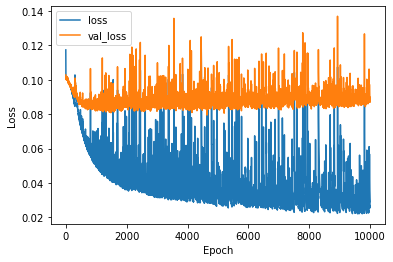

In [15]:
#Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.legend(loc='upper left')

In [15]:
# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("Ventral_3layers_weights.h5")
print("Saved model to disk")

model.save('Ventral_3layers.h5')

Saved model to disk


In [16]:
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.37895825505256653
Test accuracy: 0.6071310043334961


In [27]:
# Predict
predictions = model.predict(test_generator)

In [14]:
#this is the loop over on datagenerator to get the X and y.
data = []     # store all the generated data batches
y_true = []   # store all the generated label batches
max_iter = 94  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
i = 0
for d, l in validation_generator:
    data.append(d)
    y_true.append(l)
    i += 1
    if i == max_iter:
        break

#Now we have two lists of tensor batches.
#We need to reshape them to make two tensors, one for data (i.e X) and one for labels (i.e. y):
data = np.array(data)
data = np.reshape(data, (data.shape[0]*data.shape[1],) + data.shape[2:])
print(data.shape)

y_true = np.array(y_true)
#print(y_true.shape)
y_true = np.reshape(y_true, (y_true.shape[0]*y_true.shape[1],) + y_true.shape[2:])
print(y_true.shape)

(800, 251, 211)
(800, 251, 1007)
